# Notebook to setup the Active Optics algorithm
#### Load required libraries

In [3]:
import numpy as np
import logging
import pickle

from scipy import sparse
import scipy.linalg as la
from scipy.linalg import block_diag
import scipy.io as spio

import os
from os import path

from pathlib import Path

import matplotlib.pyplot as plt

# from ruamel import yaml
# from ruamel.yaml import YAML
# y = YAML()
# y.default_flow_style = None

In [17]:
def get_aco_recW2(Dwfs,wfsMask,DpwBM,rho_p,rho_s,**kwargs):

    try:
        plotPistonRegMat = kwargs['plotPistonRegMat']
    except:
        plotPistonRegMat = False

    if not ((Dwfs.shape[1]+2) % 7):
        mount_included = False
        n_bm = ((Dwfs.shape[1]+2)//7) - 12
    elif not ((Dwfs.shape[1]+2 -2) % 7):
        n_bm = ((Dwfs.shape[1])//7) - 12
        mount_included = True
    else:
        print('Unable to get the correct number of the calibrated bending modes. Check Dwfs!')

    # - - - Global clocking filtering: we assume that the last 12 modes refer to segment clocking
    n_r = 12
    _U,sigma,VT = np.linalg.svd(Dwfs,full_matrices=False)
    q = sigma[-n_r:]
    W2_clk = VT[-n_r:,:].T.dot(np.diag(q)).dot(VT[-n_r:,:])

     # - - - Segment piston penalization
    if mount_included:
        DpwBM = np.hstack([DpwBM, kwargs['Dp_az'], kwargs['Dp_el']])
        
    W2_piston = DpwBM.T.dot(DpwBM)

    if (plotPistonRegMat):
        import matplotlib.pyplot as plt
        fig = plt.figure(figsize=(8,4))
        plt.imshow(W2_piston[:6,:6], aspect='auto')
        plt.title('Segment Piston Penalization Matrix')
        plt.xlabel('Input mode'), plt.ylabel('Reconstructed mode')
        plt.show()

    if (False):
        import matplotlib.pyplot as plt
        fig = plt.figure(figsize=(8,4))
        plt.imshow((V_pr @ (Lambda_pr - R_g@Lambda_g@R_g.T) @ V_pr.T), aspect='auto')
        plt.show()

    W2 = W2_clk + rho_p*W2_piston

    # - - - Mean slope removal matrices (but retains the overall contribution)
    O = np.kron(np.eye(6),np.ones((48*48,1)))
    V_pr = np.zeros((Dwfs.shape[0],6))
    for iv in range(6):
        V_pr[:,iv] = np.hstack([*[O[MaskSeg.ravel(),iv] for MaskSeg in wfsMask]])
    Lambda_pr = np.diag(1/np.sum(V_pr,axis=0))

    R_g = np.kron(np.eye(2),np.array([[1,1,1]]).T)
    Lambda_g = np.diag(1/np.sum(V_pr@R_g,axis=0))        
    
    # Mean slope regularization
    if rho_s > 0.0:
        S = np.matmul(V_pr @ (Lambda_pr - R_g@Lambda_g@R_g.T) @ V_pr.T, Dwfs)
        # Update W2 mean slope regularization matrix
        W2 += rho_s*S.T.dot(S)
        
    Rs = np.eye(Dwfs.shape[0]) - (V_pr @ (Lambda_pr - R_g@Lambda_g@R_g.T) @ V_pr.T)

    return W2, Rs

In [5]:
def get_aco_recW3(rho_rbm1,rho_rbm2,rho_Fz,**kwargs):
    
    W_M1TxyzRxyz = [rho_rbm1*i_cm for i_cm in [1]*6]
    W_M2TxyzRxyz = [rho_rbm2*i_cm for i_cm in [1]*6]
    
    W_rbm_oa = block_diag(np.diag(W_M1TxyzRxyz), np.diag(W_M2TxyzRxyz))
    W_rbm_cs = block_diag(np.diag(W_M1TxyzRxyz[:-1]), np.diag(W_M2TxyzRxyz[:-1]))
    # Rescale RBM weighting matrix
    rbm_factor = 1/np.linalg.norm(W_rbm_oa)

    # OA segment SA_F weights
    W_m1oaF = np.diag([1]*165)
    W_m1oaF =  rho_Fz*(1/np.linalg.norm(W_m1oaF))*W_m1oaF
    # CS (center segment) SA_F weights
    W_m1csF = np.diag([1]*154)
    W_m1csF =  rho_Fz*(1/np.linalg.norm(W_m1csF))*W_m1csF

    
    # Group weighting matrices
    W3_M1RBM = rbm_factor*block_diag(np.kron(np.eye(6),np.diag(W_M1TxyzRxyz)),
        np.diag(W_M1TxyzRxyz[:-1]))
    W3_M2RBM = rbm_factor*block_diag(np.kron(np.eye(6),np.diag(W_M2TxyzRxyz)),
        np.diag(W_M2TxyzRxyz[:-1]))
    W3_M1BM = block_diag(np.kron(np.eye(6),W_m1oaF),W_m1csF)
    # Merge weighting matrices
    W3 = block_diag(W3_M1RBM,W3_M2RBM,W3_M1BM)

    if 'rho_m' in kwargs.keys():
        W3 = block_diag(W3,kwargs['rho_m']*np.eye(2))
    
    W3 = (1/np.linalg.norm(W3))*W3
    
    # Print reconstructor regularization weights
    if(1):
        np.set_printoptions(formatter={'float': '{: 0.6f}'.format})
        
        aux = np.diag(W3)
        if include_mount:
            print('Mount weights:\n',aux[-2:])
    
        _wM1rbm,_wM2rbm,_wSA_F = np.split(aux,[41,82],axis=0)
        print('M1 TxyzRxyz weights:\n',_wM1rbm[:5],'...(%s entries)'%_wM1rbm.shape)
        print('M2 TxyzRxyz weights:\n',_wM2rbm[:5],'...(%s entries)'%_wM2rbm.shape)
        print('Fz weights:\n',_wSA_F[:5],'...')
        np.set_printoptions(formatter=None)

    return W3

In [6]:
# Number of M1 bending modes
n_bm = 27

# Recalibration flag
recalibrate = False

# Calibration filename
fluxThreshold = 0.8
GSpos = 8 #arcmin


In [7]:
import ceo

# Pupil size
pupil_size = 25.5

# GMT with n_bm bending mode per M1 segment
n_bm = 27
# gmt_prms = {'M1_mirror_modes':u"bending modes", 'M1_N_MODE':n_bm}
gmt_prms = {'M1_mirror_modes':u"FEM_LoFiBM", 'M1_N_MODE':n_bm}


# WFS
wfs_nLenslet = 48
wfs_prms = {'N_SIDE_LENSLET':wfs_nLenslet, "N_PX_LENSLET":16,
            'd':pupil_size/wfs_nLenslet, 'DFT_osf':2, 'N_PX_IMAGE':24,
            'BIN_IMAGE':3, 'N_GS':3, 'readOutNoiseRms':0.5, 'noiseFactor':np.sqrt(2),
            'photoElectronGain':0.63,'exposureTime': 30,'intensityThreshold':0.0}
# Pupil sampled with `Npx` pixels
nPx = wfs_prms['N_SIDE_LENSLET']*wfs_prms['N_PX_LENSLET']+1

# Source: Guide Stars
zen = np.ones(3)*ceo.constants.ARCMIN2RAD*GSpos
azi = np.arange(3)*2*np.pi/3
wfs_guide_stars = {'photometric_band':"R+I",
                   'zenith':zen.tolist(), 'azimuth':azi.tolist(),
                   'magnitude':[16]*3,
                   'fwhm':3.16, 'rays_box_size':pupil_size,
                   'rays_box_sampling': nPx,'rays_origin':[0,0,25]}

# Instantiate GMT object
gmt = ceo.GMT_MX(**gmt_prms)
gmt.reset()
# Source
gs = ceo.Source(**wfs_guide_stars)
gs.reset()

/home/ubuntu/CEO/python/ceo/zemax


#### Load Active Optics Calibration Matrix

Trying to load calib_GSH8arcmin_0p8fluxTH_27BM.pickle
___ M1 ___ (Txyz)
Segment #:1 2 3 4 5 6 7 
------------
___ M2 ___ (Txyz)
Segment #:1 2 3 4 5 6 7 
------------
___ M1 ___ (Rxyz)
Segment #:1 2 3 4 5 6 7 
------------
___ M2 ___ (Rxyz)
Segment #:1 2 3 4 5 6 7 
------------
___ M1 ___ (bending modes)
Segment #0: 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 
Segment #1: 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 
Segment #2: 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 
Segment #3: 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 
Segment #4: 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 
Segment #5: 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 
Segment #6: 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 
------------
Max. flux: 1.0
# of WFS valid lenslet based on flux threshold (0.80): 3216
# of WFS val

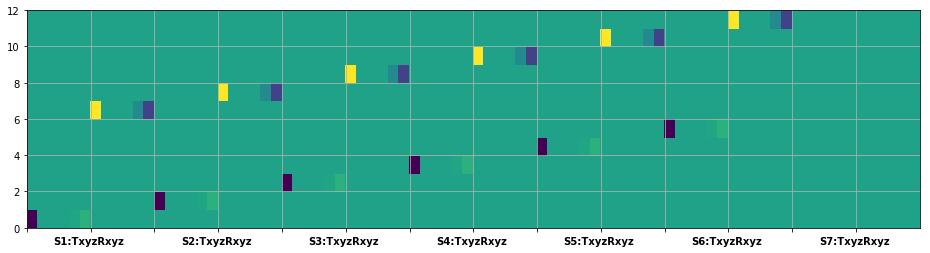

In [8]:
flux_str = str(fluxThreshold).replace(".", "p")
filename = 'calib_GSH%sarcmin_%sfluxTH_%dBM.pickle'% (GSpos,flux_str,n_bm)
print("Trying to load %s"%filename)

# Load calibration data
if (os.path.isfile(filename)) and not recalibrate:
    with open(filename,'rb') as f:
        calib_dt = pickle.load(f)
        print('Calibration data loaded from %s'%(filename))
        print(calib_dt.keys())
else:
    
    # WFS Calibration reference slopes    
    gwfs = ceo.GeometricShackHartmann(**wfs_prms)
    gs>>(gmt,gwfs)
    +gs
    gwfs.calibrate(gs,0.0)
    # Calibration settings
    pinv_calib_settings = {'n_threshold':[2]*6+[0], 'insert_zeros':[None]*6+[[5,10]]}
    # M1/M2 RBM and M1 BM Interaction matrix calibration
    CDwBM = gmt.AGWS_calibrate(gwfs, gs, decoupled=True, stroke=[1e-6]*5,
                               includeBM=True, filterMirrorRotation=False, 
                               fluxThreshold=fluxThreshold,
                               calibrationVaultKwargs=pinv_calib_settings)
    
    
    # Mount intercation matrix calibration
    gwfs.calibrate(gs,fluxThreshold)
    Dm = gmt.calibrate(gwfs,gs,'MOUNT','pointing',stroke=1e-6)
    
    
    # M1/M2 segment piston interaction matrix calibration
    print('----------\nCalibrating piston penalization matrices...\n')
    gs>>(gmt,)
    ~gmt
    +gs
    p0 = gs.piston(where='segments')
    Dp = np.zeros((21,82))

    counter, stroke, label_ax = 0, 1e-6, ['x','y','z']
    # Change order to match end2end simulations' pattern
    for mirror in ('M1','M2'):
        print(mirror,end=':=')
    #     print(mirror,end='')
        for segment in range(7):
            print(' S%s:'%str(segment+1),end='')
            for RT in ('Txyz','Rxyz'):
                print(RT[0],end='')
                for axis in range(3):
                    if segment==6 and RT=='Rxyz' and axis==2:
                        if(Dp.shape[1] == 84):
                            print(end='_')
                            counter += 1 
                        continue
                    print(label_ax[axis],end='')
                    ~gmt
                    state = gmt.state
                    state[mirror][RT][segment,axis] = stroke
                    gmt^=state
                    +gs
                    p = gs.piston(where='segments')   
                    Dp[:,counter] = np.reshape((p-p0)/stroke,21)
                    print('(%s)'%str(counter),end='')
                    counter += 1                
        print('')
        
    # Mount modes induced piston interaction matrix calibration
    #gs>>(gmt,)    
    ~gmt
    +gs
    #p0 = gs.piston(where='segments')
    stroke = 1e-6
    # AZ
    mount_az, mount_el = stroke, 0.0
    gmt.pointing_error_zenith = np.hypot(mount_az,mount_el)
    gmt.pointing_error_azimuth = np.arctan2(mount_el,mount_az)
    +gs
    p1 = gs.piston(where='segments')
    Dp_az = np.reshape((p1-p0)/stroke,(21,1))
    # EL
    mount_az, mount_el = 0.0, stroke
    gmt.pointing_error_zenith = np.hypot(mount_az,mount_el)
    gmt.pointing_error_azimuth = np.arctan2(mount_el,mount_az)
    +gs
    p1 = gs.piston(where='segments')
    Dp_el = np.reshape((p1-p0)/stroke,(21,1))
    
    
    # Global clocking
    stroke = 1e-5  #rad
    # A matrix containing the 12 column vectors related to outer-segment clocking modes
    global_clk = np.zeros((12*7,12))
    for jj in  range(6):
        # M1 OA clocking
        gmt.reset()
        gmt.M1.transform([0]*3,[0,0,stroke], segId=[jj+1])
        global_clk[:,jj] = np.concatenate((gmt.state['M1']['Txyz'],
                                       gmt.state['M1']['Rxyz'],
                                       gmt.state['M2']['Txyz'],
                                       gmt.state['M2']['Rxyz']),axis=1).ravel() / stroke
        # Normalize the linear combination
        global_clk[:,jj] = global_clk[:,jj]/la.norm(global_clk[:,jj])
        # M2 OA clocking
        gmt.reset()
        gmt.M2.transform([0]*3,[0,0,stroke], segId=[jj+1])
        global_clk[:,jj+6] = np.concatenate((gmt.state['M1']['Txyz'],
                                       gmt.state['M1']['Rxyz'],
                                       gmt.state['M2']['Txyz'],
                                       gmt.state['M2']['Rxyz']),axis=1).ravel() / stroke
        # Normalize the linear combination
        global_clk[:,jj+6] = global_clk[:,jj+6]/la.norm(global_clk[:,jj+6])
    
    if(1):
        fig,ax = plt.subplots()
        fig.set_size_inches(16,4)
        plt.pcolor(global_clk.T)
        ax.grid()
        ax.set_xticks(np.arange(0,84,6));
        labelsDT = [ax.text(x+2.5,-1.0,f'S{(k % 7)+1}:TxyzRxyz',
                            verticalalignment='bottom',fontweight='bold') 
                    for k,x in enumerate(range(0,84,12),0)]    
        ax.set_xticklabels(labels = [])
        # global_clk[:,6]   
    
    
       
    # Calibration data
    calib_dt = {'wfs_prms':wfs_prms,
                'wfs_guide_stars':wfs_guide_stars,
                'D':CDwBM.D, 'Dm': Dm, 'wfsMask': CDwBM.valid,
                'gb_clk':global_clk.T, 'Dp': Dp, 'Dp_az': Dp_az, 'Dp_el': Dp_el}
    # Save calibration data
    with open(filename,'wb') as f:
        pickle.dump(calib_dt,f)
    print('Calibration data saved as %s'%(filename))
        
# Valid lenslets mask
wfsMask = calib_dt['wfsMask']
# SH-WFS interaction matrix: D:=M1/M2, Dm:=mount
D, Dm = calib_dt['D'], calib_dt['Dm']
print("-> %dx%d Piston interaction matrix was loaded successfully."%(Dp.shape[0],Dp.shape[1]))
# Other influence matrices: Piston and clocking matrices
Dp, Dp_az, Dp_el = calib_dt['Dp'], calib_dt['Dp_az'], calib_dt['Dp_el']
gb_clk = calib_dt['gb_clk']

In [9]:
# Flag to include mount controllable modes
include_mount = False

dict_keys(['De', 'wfs48', 'D', 'wfsMask', 'M'])


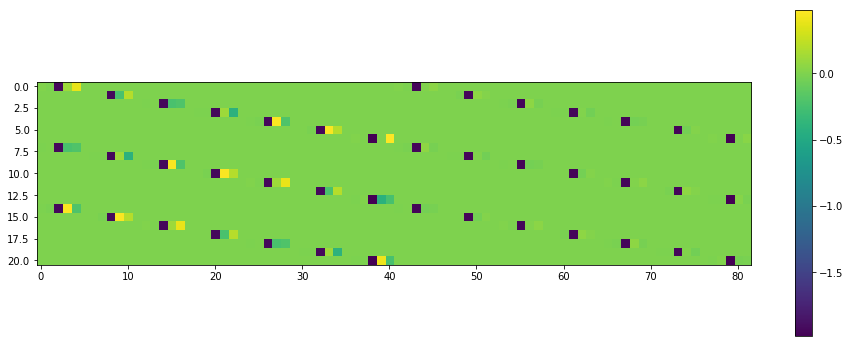

In [10]:
dt = np.load('../Calibration/calib_dt_GSH0p5fluxTH_46BM_LoFi.npz', allow_pickle=True)
print(dt['calibdt'][()].keys())
#M1-RBM
Dm1 = block_diag(*[Dseg[:,:6] for Dseg in dt['calibdt'][()]['D'][:-1]])
Dm1 = block_diag(Dm1,dt['calibdt'][()]['D'][-1][:,:5])
#M2-RBM
Dm2 = block_diag(*[Dseg[:,6:12] for Dseg in dt['calibdt'][()]['D'][:-1]])
Dm2 = block_diag(Dm2,dt['calibdt'][()]['D'][-1][:,5:10])
#M1BM
Dbm = block_diag(*[Dseg[:,12:12+n_bm] for Dseg in dt['calibdt'][()]['D'][:-1]])
Dbm = block_diag(Dbm,dt['calibdt'][()]['D'][-1][:,10:10+n_bm])

# Compute SH-WFS consolidated interaction matrix (FEM compatible ordering)
Dsh = np.hstack((Dm1,Dm2,Dbm))


dt_p = np.load('../Calibration/piston_mount_calib_dt_end2end.npz', allow_pickle=True)
plt.figure(figsize=(16,6))
plt.imshow(dt_p['calibdt'][()]['Dp'][:,:])

plt.colorbar()

In [11]:
# Compute SH-WFS consolidated interaction matrix

Dm1 = block_diag(*[Dseg[:,:6] for Dseg in D[:-1]])
Dm1 = block_diag(Dm1, D[-1][:,:5])

Dm2 = block_diag(*[Dseg[:,6:12] for Dseg in D[:-1]])
Dm2 = block_diag(Dm2, D[-1][:,5:10])

Dbm = block_diag(*[Dseg[:,12:12+n_bm] for Dseg in D[:-1]])
Dbm = block_diag(Dbm, D[-1][:,10:10+n_bm])

Dsh = np.hstack((Dm1, Dm2, Dbm))

#Dsh = la.block_diag(*[Dseg[:,:12+n_bm] for Dseg in D[:-1]])
#Dsh = la.block_diag(Dsh,D[-1][:,:10+n_bm])
print("-> %dx%d interaction matrix was loaded successfully."%
      (Dsh.shape[0],Dsh.shape[1]))


-> 6432x271 interaction matrix was loaded successfully.


Plot comparison of singular values with and without Mount axes

In [12]:
if (False) and include_mount:
    U,sigma,V = np.linalg.svd(Dwfs[:,:-2], full_matrices=False)        
    print('Weakest singular values :\n',sigma[-15:])
    U_,sigma_,V_ = np.linalg.svd(Dwfs, full_matrices=False)
    import matplotlib.pyplot as plt
    plt.figure(figsize=(16,6))    
    plt.semilogy(sigma[:],'s-', label='wo mount')
    plt.semilogy(sigma_[:], 'd-.', label='with mount')
    plt.grid()
    plt.legend()
    plt.xlabel('# Mode')
    plt.ylabel('Dwfs singular values')
    plt.show()

#### AcO reconstructor+controller settings

In [32]:
if include_mount:
    Dsh = np.hstack([Dsh, Dm])

# Maximum actuator command values
# [ID 36136]: M1 Segment Active Optics Range of Motion
max_m1RBM = [3.0e-3,4.75e-3,4e-3] + [6.5e-4,5.75e-4,5.75e-4]
# [ID 36168]: M2 Segment Active Optic Range of Motion
# max_m2RBM = [11.0e-3,11.0e-3,12.0e-3] + [3e-3,3e-3,3e-3]
max_m2RBM = [3.0e-4,3.0e-4,3.0e-4] + [3.5e-3,3.5e-3,3.5e-3]
max_Fz = 147
max_az_el = [1e-2,1e-2]

# AcO configuration parameters
rho_p = 1.0e-3 #5.0e-4 #5.0e-6
rho_s = 0.0*1.0e-8
rho_rbm1 = 4
rho_rbm2 = 1
rho_Fz = 0.1*(12/165)**2
rho_m = 50
    

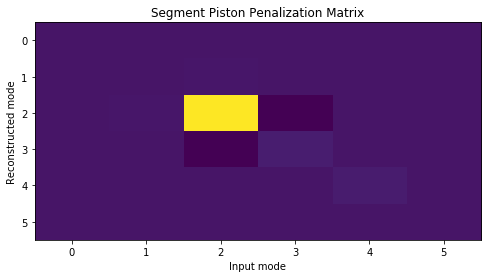

M1 TxyzRxyz weights:
 [ 0.151511  0.151511  0.151511  0.151511  0.151511] ...(41 entries)
M2 TxyzRxyz weights:
 [ 0.037878  0.037878  0.037878  0.037878  0.037878] ...(41 entries)
Fz weights:
 [ 0.000016  0.000016  0.000016  0.000016  0.000016] ...

Dimension of the vector of actuator limits:1228


In [33]:
# Get weighting matrices

if (Dp.shape[1] == 82):
    # Include zero columns corresponfing to bending modes 
    DpwBM = np.hstack([Dp, np.zeros((Dp.shape[0],7*n_bm))])
else:
    print('There is an unexpected number of columns in Piston calibration matrix Dp!')

if not include_mount:
    W2, Rs = get_aco_recW2(Dsh, wfsMask, DpwBM=DpwBM, rho_p=rho_p, rho_s=rho_s,plotPistonRegMat=True)#, gb_clk=gb_clk)
    W3 = get_aco_recW3(rho_rbm1=rho_rbm1, rho_rbm2=rho_rbm2, rho_Fz=rho_Fz)
else:
    W2, Rs = get_aco_recW2(Dsh, wfsMask, DpwBM=DpwBM, rho_p=rho_p, rho_s=rho_s, 
                                    Dp_az=Dp_az,Dp_el=Dp_el)
    W3 = get_aco_recW3(rho_rbm1=rho_rbm1, rho_rbm2=rho_rbm2, rho_Fz=rho_Fz, rho_m=rho_m)

# Print reconstructor regularization weights
if(0):
    np.set_printoptions(formatter={'float': '{: 0.6f}'.format})
    # Include M1/M2 S7 Rz
    aux = np.insert(np.diag(W3),[72+(165*6)+5,72+(165*6)+10],0)
    if include_mount:
        print('Mount weights:\n',aux[-2:])
        aux = np.reshape(np.append(aux[:-2],np.array([0]*11)),[7,12+165])
    else:
        aux = np.reshape(np.append(aux,np.array([0]*11)),[7,12+165])    
   # Get weights from split     
    _wM1rbm,_wM2rbm,_wBM = np.split(aux,[6,12],axis=1)
    print('M1/TxyzRxyz weights:\n',_wM1rbm[[0,6]])
    print('M2/TxyzRxyz weights:\n',_wM2rbm[[0,6]])
    print('Fz weights:\n',_wBM[0,:5],'...')
    np.set_printoptions(formatter=None)


# Bending modes' data
Afz = {}
# OA segment weights
filepath = os.path.join('../gmt_model_dt','m1s1_Af.mat')
Afz['outer'] = spio.loadmat(filepath)['afprime']
_U,s_oa,V_oaT = la.svd(Afz['outer'],0)
bm2Fz_oa = np.dot(V_oaT.T, np.diag(1/s_oa)[:,:n_bm])
# CS (center segment) weights
filepath = os.path.join('../gmt_model_dt','m1s7_Af.mat')
Afz['center'] = spio.loadmat(filepath)['afprime']
_U,s_cs,V_csT = la.svd(Afz['center'],0)
bm2Fz_cs = np.dot(V_csT.T, np.diag(1/s_cs)[:,:n_bm])


# Transformation matrix from ctrlb modes to actuator action domain
fz_factor = np.mean(max_m1RBM + max_m2RBM)/max_Fz
_Tu = block_diag( np.eye(84), np.kron(np.eye(6),fz_factor*bm2Fz_oa), fz_factor*bm2Fz_cs)
_TuwoS7Rz = block_diag( np.eye(82), np.kron(np.eye(6),fz_factor*bm2Fz_oa), fz_factor*bm2Fz_cs)
# Actuator ranges [M1_RBM;M2_RBM;M1_SA_F]
rbm_ranges = max_m1RBM*7 + max_m2RBM*7
u_ranges = rbm_ranges + [fz_factor*max_Fz]*bm2Fz_oa.shape[0]*6 + [fz_factor*max_Fz]*bm2Fz_cs.shape[0]
print('\nDimension of the vector of actuator limits:%d'%len(u_ranges))

# Control action upper limits vector
umax = np.array(u_ranges) # np.array([]) # 
    
if include_mount:
    _Tu = block_diag(_Tu,np.eye(2))
    _TuwoS7Rz = block_diag(_TuwoS7Rz,np.eye(2))
    umax = np.hstack([umax, np.array(max_az_el)]) # np.array([]) #

# AcO integral controller gain
k_I = 0.5

# Active Optics dictionary data
W3 = _TuwoS7Rz.T @ W3 @ _TuwoS7Rz


data = {'SHAcO_qp':{'D':Dsh,'W2':W2,'W3':W3,'K':k_I,
                    'wfsMask':calib_dt['wfsMask'],
                    'umin':-umax, 'umax':umax,'rm_mean_slopes':True,
                    '_Tu':_Tu, 'rho_3':1.0e-1, 'end2end_ordering':True}} #'J1_J3_ratio':10

Save AcO tuning file

In [34]:
acogain_str = str(k_I).replace(".", "p")
rhoP_str = np.log10(rho_p)
AcO_filename = 'SHAcO_qp_rhoP1e%.1g_k%s.pickle'% (rhoP_str,acogain_str)
print(AcO_filename, rho_p)

SHAcO_qp_rhoP1e-3_k0p5.pickle 0.001


In [35]:
# AcO_filename = 'SHAcO_qp_rhoP5e-4_k0p5.pickle'
# Pickles MPC data into string representation
with open(AcO_filename,'wb') as f:
    pickle.dump(data,f)
    print('AcO data saved as %s' %AcO_filename)

AcO data saved as SHAcO_qp_rhoP1e-3_k0p5.pickle


Check conditioning improvement due to regularization

In [36]:
condDTD = np.linalg.cond(Dsh.T.dot(Dsh))
print('Condition number improvement:\n')
print('Due to W2:',condDTD/np.linalg.cond(Dsh.T.dot(Dsh)+W2))
print('Due to W2 and W3:',condDTD/np.linalg.cond(Dsh.T.dot(Dsh)+W2+5.0e-7*k_I*W3*k_I))

Condition number improvement:

Due to W2: 57006.44470090717
Due to W2 and W3: 59921.970047033225


Cells to evaluate the AcO reconstructor

In [24]:
def plot_AcO_RdotD(RD,m1_cmap='Spectral'):
    plt.figure(figsize=(14,5))
    # M1 modes
    plt.subplot(1,2,1)
    m1RD = RD[:42,:42]
    pcm1 = plt.imshow(m1RD,cmap=plt.get_cmap(m1_cmap))
    plt.colorbar(pcm1,label='Contribution (Gain)')
    plt.title('M1 reconstruction')
    cn = 4
    for k in range(6):
        plt.axhspan(6*k,6*(k+1), color=f'C{(k%2)+cn}', alpha=0.1)
        plt.axvspan(6*k,6*(k+1), color=f'C{(k%2)+cn}', alpha=0.1)
        plt.axvspan(6*(k+1),6*(k+1), color=f'C{cn}', alpha=0.3)
        plt.axhspan(6*(k+1),6*(k+1), color=f'C{cn}', alpha=0.3)
        
    labelsDT = [plt.text(x+1.5,42,f'S{(k % 7)+1}',verticalalignment='top',fontweight='bold') 
                for k,x in enumerate(range(0,42,6),0)]            
    labelsDT = [plt.text(-3.5,y+4,f'S{(k % 7)+1}',horizontalalignment='left',fontweight='bold') 
                for k,y in enumerate(range(0,42,6),0)]
    plt.yticks(np.arange(0,42,6),labels = []); plt.xticks(np.arange(0,42,6),labels = [])  

    # M2 modes
    plt.subplot(1,2,2)
    m2RD = RD[42:84,42:84]
    pcm2=plt.imshow(m2RD,vmax=np.max(m2RD),vmin=-np.max(m2RD),cmap=plt.get_cmap('Spectral'))
    plt.colorbar(pcm2,label='Contribution (Gain)')
    plt.title('M2 reconstruction')
    for k in range(6):
        plt.axhspan(6*k,6*(k+1), color=f'C{(k%2)+cn}', alpha=0.1)
        plt.axvspan(6*k,6*(k+1), color=f'C{(k%2)+cn}', alpha=0.1)
        plt.axvspan(6*(k+1),6*(k+1),color=f'C{cn}', alpha=0.3)
        plt.axhspan(6*(k+1),6*(k+1), color=f'C{cn}', alpha=0.3)
        
    labelsDT = [plt.text(x+1.5,42,f'S{(k % 7)+1}',verticalalignment='top',fontweight='bold') 
                for k,x in enumerate(range(0,42,6),0)]            
    labelsDT = [plt.text(-3.5,y+4,f'S{(k % 7)+1}',horizontalalignment='left',fontweight='bold') 
                for k,y in enumerate(range(0,42,6),0)]
    plt.yticks(np.arange(0,42,6),labels = []); plt.xticks(np.arange(0,42,6),labels = [])
    # OA & CS Segments
    plt.figure(figsize=(14,3))

    titles = ['M1-S1(OA)','M1-S7(CS)','M2-S1(OA)','M2-S7(CS)']
    ticklabels = ['Tx','Ty','Tz','Rx','Ry','Rz']
    res = [RD[:6,:6],RD[36:42,36:42],RD[42:48,42:48],RD[78:84,78:84]]
    vlim = [np.max(m1RD),np.max(m2RD)]
    for k in range(4):
        plt.subplot(1,4,k+1)
        plt.imshow(res[k],vmax=vlim[np.int(k/2)],vmin=-vlim[np.int(k/2)],cmap=plt.get_cmap('Spectral'))
        plt.title(titles[k])
        for k in range(6):
            plt.axvspan((k+.45),(k+.45),color=f'C{cn}', alpha=0.2)
            plt.axhspan((k+.45),(k+.45), color=f'C{cn}', alpha=0.2)
        labelsDT = [plt.text(x-0.3,5.8,ticklabels[kk],verticalalignment='top',fontweight='bold') 
                for kk,x in enumerate(range(0,6),0)]            
        labelsDT = [plt.text(-1.35,y+.15,ticklabels[kk],horizontalalignment='left',fontweight='bold') 
                for kk,y in enumerate(range(0,6),0)]
        plt.yticks(np.arange(6),labels = []); plt.xticks(np.arange(6),labels = [])

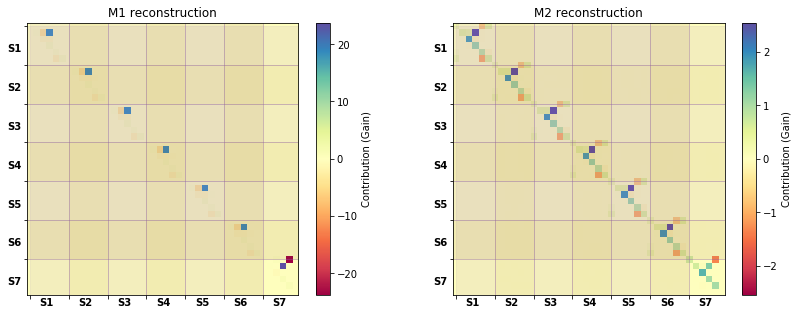

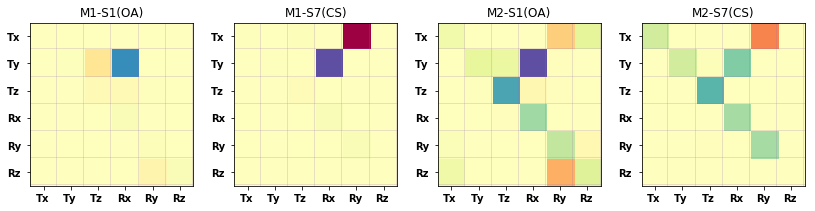

In [37]:
W2, Rs = get_aco_recW2(Dsh, wfsMask, DpwBM=DpwBM, rho_p=1e-3, rho_s=rho_s)#, gb_clk=gb_clk)

# - - - NO Probe mean slope removal matrix Rs 
left_sym_inv = la.pinv(Dsh.T.dot(Dsh) + W2)
R = left_sym_inv.dot(Dsh.T)
R = np.insert(R,[36+5,82],0,axis=0)
# Linear reconstruction bias
Dwfs_withS7Rz = np.insert(Dsh,[36+5,82],0,axis=1)

RD = R.dot(Dwfs_withS7Rz)
plot_AcO_RdotD(RD)


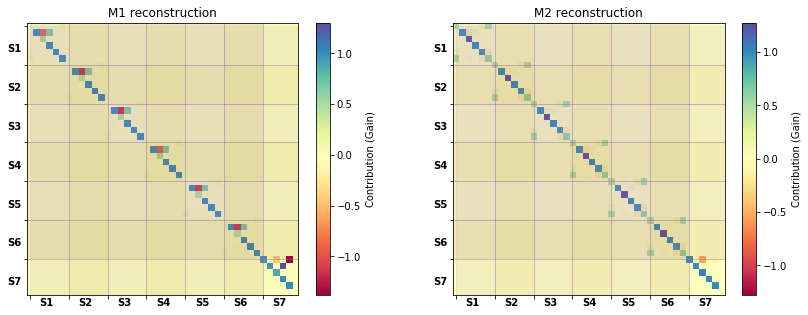

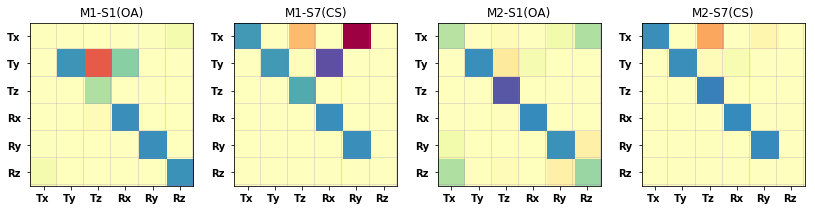

In [40]:
W2, Rs = get_aco_recW2(Dsh, wfsMask, DpwBM=DpwBM, rho_p=1e-6, rho_s=rho_s)#, gb_clk=gb_clk)

# - - - NO Probe mean slope removal matrix Rs 
left_sym_inv = la.pinv(Dsh.T.dot(Dsh) + W2)
R = left_sym_inv.dot(Dsh.T)
R = np.insert(R,[36+5,82],0,axis=0)

# Linear reconstruction bias
Dwfs_withS7Rz = np.insert(Dsh,[36+5,82],0,axis=1)
RD = R.dot(Dwfs_withS7Rz)
plot_AcO_RdotD(RD)
